In [1]:
from multiobjective_opt.neural_net.mab_classes import (
    EvalCriterion, 
    NeuralArmEnv, 
    NeuralRewardEstimator,
    TrainHyperparameters
)
from multiobjective_opt.neural_net.runner import NeuralRunner

from multiobjective_opt.mab.agents import UCB, EpsGreedy

from multiobjective_opt.neural_net.train.train_cifar import get_models
from multiobjective_opt.neural_net.utils import funcs
from multiobjective_opt.neural_net.utils.dataset_prepare import CIFAR10Handler

def get_runner(num_pulls=200, dataloader_cycled=True, dataloader_iters=50, datasets_path = None, train_hyperparams = None, **kwargs):
    
    # set up models
    models = get_models()
    model_names = models.keys()
    models_list = models.values()

    # ????
    model_params = []
    for _ in models_list:
        model_params.append({})

    data_loader = CIFAR10Handler(dataloader_cycled, dataloader_iters, root = datasets_path)
    train_hyperparams = TrainHyperparameters(**train_hyperparams)

    # set up environment
    env = NeuralArmEnv(
        models=models_list,
        model_params=model_params,
        model_names=model_names,
        data_loader=data_loader,
        eval_criterion=EvalCriterion.LOSS,
        train_hyperparams=train_hyperparams,
    )

    # set up agent
    coeff_scaler = 4.
    n_actions = len(models)
    reward_estimator = NeuralRewardEstimator(
        n_actions=n_actions, 
        coeff_scaler=coeff_scaler)
    
    agent = UCB(
        n_actions=n_actions, 
        reward_estimator=reward_estimator
    )
    runner = NeuralRunner(
        environment=env,
        agent=agent        
        )
    return runner




    

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../conf/cv"):
    cfg = compose(config_name="config", overrides=['paths.root=".."'])


runner = get_runner(datasets_path = cfg.paths.datasets_path, **cfg.experiment.mab_params)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
from multiobjective_opt.neural_net.mab_classes import EvalRez, NeuralReward


a = NeuralReward(3, 1, EvalRez(0.1, 0.4, 1))

In [16]:
from dataclasses import asdict, fields, is_dataclass
from typing import Any, Dict

def flatten_dataclass(obj: Any, parent_key: str = '', sep: str = '.') -> Dict[str, Any]:
    """Рекурсивно 'разворачивает' датакласс в плоский словарь."""
    flat_dict = {}
    
    if is_dataclass(obj):
        for field in fields(obj):
            field_value = getattr(obj, field.name)
            new_key = f"{parent_key}{sep}{field.name}" if parent_key else field.name
            flat_dict.update(flatten_dataclass(field_value, new_key, sep))
    elif isinstance(obj, (list, tuple)):
        for i, item in enumerate(obj):
            new_key = f"{parent_key}{sep}{i}" if parent_key else str(i)
            flat_dict.update(flatten_dataclass(item, new_key, sep))
    elif isinstance(obj, dict):
        for k, v in obj.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            flat_dict.update(flatten_dataclass(v, new_key, sep))
    else:
        if parent_key:  # Игнорируем "лишние" ключи для примитивов
            flat_dict[parent_key] = obj
    return flat_dict
            
flatten_dataclass({"test": a})

{'test.value': 3,
 'test.confidence_bound': 1,
 'test.eval_rez.accuracy': 0.1,
 'test.eval_rez.loss': 0.4,
 'test.eval_rez.duration': 1}

In [3]:
res = runner.run(20)

Training steps: 100%|██████████| 20/20 [02:32<00:00,  7.64s/it]


In [4]:
res.rewards_history

[NeuralReward(value=2.1243199630737304, confidence_bound=1.0, eval_rez=EvalRez(accuracy=0.1808, loss=2.1243199630737304, duration=17.057542324066162)),
 NeuralReward(value=2.088277311706543, confidence_bound=1.0, eval_rez=EvalRez(accuracy=0.2078, loss=2.088277311706543, duration=23.829054594039917)),
 NeuralReward(value=2.3484240467071533, confidence_bound=1.0, eval_rez=EvalRez(accuracy=0.184, loss=2.3484240467071533, duration=31.91183567047119)),
 NeuralReward(value=1.7759341159820556, confidence_bound=1.0, eval_rez=EvalRez(accuracy=0.3894, loss=1.7759341159820556, duration=39.45068979263306)),
 NeuralReward(value=1.9379272029876708, confidence_bound=1.0, eval_rez=EvalRez(accuracy=0.2872, loss=1.9379272029876708, duration=46.741445541381836)),
 NeuralReward(value=1.7479861263275147, confidence_bound=0.7071067811865475, eval_rez=EvalRez(accuracy=0.3854, loss=1.7479861263275147, duration=55.91083598136902)),
 NeuralReward(value=2.0447937816619874, confidence_bound=0.7071067811865475, ev

Experiment with computer vision model

In [5]:
%load_ext autoreload
%autoreload 2
from dataclasses import MISSING, asdict, dataclass, field, fields
from typing import List

from multiobjective_opt.neural_net.models.cifar_parametrized import ResNet


@dataclass
class ResNetParams:
    num_blocks: List = field(
        default_factory=lambda: [2, 2, 2, 2]
    )  # Количество блоков в каждом слое
    num_filters: int = 32  # Количество фильтров в начальном слое
    use_batchnorm: bool = False  # Использовать BatchNorm
    use_dropout: bool = False  # Использовать Dropout
    dropout_prob: float = 0.5  # Вероятность дропаут

In [6]:
a = ResNetParams()
model = ResNet(**asdict(a))
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

2792810


In [7]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Пример данных: список наблюдений (x_i, t_i)
observations = [
    (np.array([1, 2, 3]), np.array([0, 1, 2])),  # Наблюдение 1
    (np.array([2, 3, 4]), np.array([0.5, 1.5, 2.5])),  # Наблюдение 2
    (np.array([1.5, 2.5, 3.5]), np.array([0.2, 1.2, 2.2]))  # Наблюдение 3
]

def interpolated_graphs(values, times):
    """
    values [n_runs x n_arms x n_observations]
    times [n_runs x n_arms x n_observations]
    """
# Шаг 1: Создать общую временную сетку
min_time = min(min(t) for _, t in observations)
max_time = max(max(t) for _, t in observations)
time_grid = np.linspace(min_time, max_time, num=100)  # 100 точек на сетке

# Шаг 2: Интерполировать данные на общей сетке
interpolated_data = []
for x, t in observations:
    interp_func = interp1d(t, x, kind='linear', fill_value="extrapolate")
    interpolated_data.append(interp_func(time_grid))

# Шаг 3: Агрегировать данные
interpolated_data = np.array(interpolated_data)  # Преобразовать в массив NumPy

# Среднее значение
mean_values = np.mean(interpolated_data, axis=0)

# Квантили (например, 0.1 и 0.9)
quantile_10 = np.quantile(interpolated_data, q=0.1, axis=0)
quantile_90 = np.quantile(interpolated_data, q=0.9, axis=0)

# Результаты
results = pd.DataFrame({
    "time": time_grid,
    "mean": mean_values,
    "quantile_10": quantile_10,
    "quantile_90": quantile_90
})


In [8]:
data

NameError: name 'data' is not defined

In [ ]:
import pickle
from tabulate import tabulate
with open("../exp_results/cv/cifar10_different.pkl", "rb") as f:
    data = pickle.load(f)
    data =data[:-1]

headers = ["Model name", "Train loss", "Model Accuracy", "Model loss", "runtime", "epochs"]
print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
# print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="latex"))

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model name   ┃   Train loss ┃   Model Accuracy ┃   Model loss ┃   runtime ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ MobileNetV2  ┃           26 ┃            0.533 ┃        1.283 ┃     2.193 ┃
┃ ShuffleNetV2 ┃           26 ┃            0.545 ┃        1.263 ┃     2.193 ┃
┃ CifarResNet  ┃           23 ┃            0.506 ┃        1.413 ┃     2.331 ┃
┃ MobileNetV2  ┃           25 ┃            0.534 ┃        1.396 ┃     2.236 ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━┛


In [ ]:
import json

with open("../exp_results/cv/cifar10_different.json", "r") as f:
    bounds = json.load(f)

def get_times():
    model_time = {i: 0. for i in range(9)}
    model_time[0] = bounds[0][1]
    for i in range(1, len(bounds)):
        model_time[bounds[i][0]] += bounds[i][1] - bounds[i-1][1]
    return model_time

times_online = get_times()

import pickle
from tabulate import tabulate
with open("../exp_results/cv/cifar10_different.pkl", "rb") as f:
    data_mab = pickle.load(f)
runtime = data_mab[-1]
data_mab = data_mab[:-1]
for i, elem in enumerate(data_mab):
    elem[0] = f"{elem[0]}_{i}"
    del elem[-1]
    elem.append(times_online[i])
headers = [
        "Model name",
        "model pulls",
        "Model Accuracy",
        "Model loss",
        # "Confidence interval",
        "Runtime"
    ]

print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
# print(tabulate(data_mab, headers=headers, floatfmt=".3f", tablefmt="latex"))
print(runtime)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model name   ┃   model pulls ┃   Model Accuracy ┃   Model loss ┃   Runtime ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ MobileNetV2  ┃            26 ┃            0.533 ┃        1.283 ┃     2.193 ┃
┃ ShuffleNetV2 ┃            26 ┃            0.545 ┃        1.263 ┃     2.193 ┃
┃ CifarResNet  ┃            23 ┃            0.506 ┃        1.413 ┃     2.331 ┃
┃ MobileNetV2  ┃            25 ┃            0.534 ┃        1.396 ┃     2.236 ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━┛
279.12013483047485


In [ ]:
# в одну табличку
data_all = []
for full_tr, online_tr in zip(data, data_mab):
    elem = [full_tr[0], online_tr[1], online_tr[2], online_tr[4], full_tr[2], full_tr[4]]
    data_all.append(elem)
headers = [
        "Model name",
        "model pulls",
        "Online Accuracy",
        "Online Runtime",
        "Full Accuracy",
        "Full Runtime"
    ]

# print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
print(tabulate(data_all, headers=headers, floatfmt=".3f", tablefmt="latex"))
print(runtime)

\begin{tabular}{lrrrrr}
\hline
 Model name   &   model pulls &   Online Accuracy &   Online Runtime &   Full Accuracy &   Full Runtime \\
\hline
 ResNet\_0     &            41 &             0.718 &          316.615 &           0.724 &       1004.294 \\
 ResNet\_1     &            42 &             0.727 &          154.768 &           0.756 &        946.506 \\
 ResNet\_2     &            49 &             0.725 &          194.925 &           0.760 &        276.188 \\
 ResNet\_3     &           108 &             0.819 &         1069.787 &           0.873 &        740.204 \\
 ResNet\_4     &           113 &             0.842 &          486.925 &           0.858 &        579.696 \\
 ResNet\_5     &           169 &             0.841 &          768.587 &           0.851 &        844.796 \\
 ResNet\_6     &           178 &             0.830 &         1758.527 &           0.871 &        903.429 \\
 ResNet\_7     &           154 &             0.808 &          662.013 &           0.826 &        28

In [ ]:
import numpy as np
def get_history(field_name):
    b = [bb[2][field_name] for bb in bounds[:9]]
    bounds_history = np.zeros((len(bounds), 9))
    bounds_history[0] = b
    for i, hist_el in enumerate(bounds[9:], 1):
        arm = hist_el[0]
        ucb = hist_el[2][field_name]
        b[arm] = ucb
        bounds_history[i] = b
    bounds_history = bounds_history[:-9].T
    return bounds_history

loss_hist = get_history("loss")
bound_hist = get_history("ucb_val")

import matplotlib.pyplot as plt

colors = ["r", "g", "black", 'y', "navy", 'lightgreen', "brown", "blue", "purple"]
for i, (loss, bound, color) in enumerate(zip(loss_hist, bound_hist, colors)):
    plt.plot(loss, label = f"ResNet-{i}", color = color)
    x = np.arange(len(loss))
    plt.fill_between(x, bound, loss,color=color,
                    alpha=0.1,)
plt.ylim((-2, 3.5))
plt.xlabel(r"$\#$ iterations.")
plt.ylabel("Loss")
plt.legend()

### mlflow example


In [ ]:
import mlflow
import os
print(os.getcwd())
if os.getcwd().endswith("/multiobjective_opt/notebooks"):
    os.chdir("..")

/home/xxam_xam/my_files/multiobjective_opt/notebooks


In [ ]:
runs = mlflow.get_experiment_by_name("cifar10_mix_80")
runs = mlflow.search_runs([runs.experiment_id])

In [ ]:
from tabulate import tabulate
import json

full_train_pos = runs["tags.mlflow.runName"].apply(lambda x: x.startswith("full_train"))
run_id = runs[full_train_pos]["run_id"].values[0]
artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="run_results_table.json")

with open(artifact_path, "r") as f:
    f = json.load(f)

print(tabulate(list(f.values())[1], headers=list(f.values())[0], floatfmt=".3f", tablefmt="heavy_outline"))

IndexError: index 0 is out of bounds for axis 0 with size 0

нарисуем

In [ ]:

exps = runs[runs['tags.mlflow.runName'].apply( lambda x: True)]
for run_id in exps['run_id']:
    try:
        artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="run_results_table.json")

        with open(artifact_path, "r") as f:
            tab = json.load(f)
        break
    except Exception as e:
        continue
    # print(tabulate(list(tab.values())[1], headers=list(tab.values())[0], floatfmt=".3f", tablefmt="heavy_outline"))

In [ ]:
[i[0] for i  in tab['data']]

['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGGLike', 'DeepMLP']

In [ ]:
durations = []
for run_id in exps['run_id']:
    artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
    artifact_path
    with open(artifact_path, "r") as f:
            rf = json.load(f)
    durations.append(rf[-1]['duration'])

    # for i in range(7):
    #     rf[i] = {"arm": rf[i][0],"duration": rf[i][1], "pull_res": rf[i][2]}

OSError: No such file or directory: '/home/xxam_xam/my_files/multiobjective_opt/mlruns/664039046244874949/1ce34aefb9ac4b209185cbf0c61244fe/artifacts/ucb_values.json'

In [ ]:
durations = np.array(durations)
durations /= 60
np.mean(durations), np.std(durations)

NameError: name 'np' is not defined

In [ ]:
def parse_values(f, n_arms = 5):
    def get_placeholder_for_val():
        return np.zeros((len(f) - n_arms,n_arms))
    duration = np.zeros(n_arms, float)
    key_res = {key: get_placeholder_for_val() for key in f[0].keys()}
    for i, elem in enumerate(f[:n_arms]):
        # инициализируем значения
        arm = elem['arm']
        duration[arm] = elem["duration"] - (f[i-1]["duration"] if i > 0 else 0)
        for k, v in elem.items():
            key_res[k][0][arm] = v
    
    # заполнение
    for i, elem in enumerate(f[n_arms:-1], 1):
        arm = elem['arm']
        duration[arm] += elem["duration"] - f[ i + n_arms - 2]["duration"]

        for k, v in elem.items():
            key_res[k][i] = key_res[k][i - 1]
            key_res[k][i][arm] = v

    return duration, key_res

In [ ]:
import numpy as np
client = mlflow.MlflowClient()
keys = ["arm", "loss", "accuracy", "test_accuracy", "test_loss", "duration"]

results = []
for run_id in exps['run_id']:
    # process for one run
    # try:
        run_res = [dict() for _ in range(355)]
        for key in keys:
                metric_h = client.get_metric_history(run_id, key=key)
                if len(metric_h)<330:
                      continue
                for i, elem in enumerate(metric_h):
                    run_res[i][key] = int(elem.value) if key == "arm" else elem.value
            
        print(run_res)
        if len(run_res[0]) < 1:
               continue
        parsed_run = parse_values(run_res)
        results.append(parsed_run)
    # except IndexError as e:
            

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},

In [ ]:
len(results)

8

In [ ]:
import numpy as np
run_loss_hist = []
for run_id in exps['run_id']:
    try:
        artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
        with open(artifact_path, "r") as f:

            
                rf = json.load(f)
    except Exception as e:
         continue
    
    if len(rf) >= 200:
        duration, key_res = parse_values(rf)

        loss_hist = key_res['loss'].T
        run_loss_hist.append(loss_hist)

delta graph

ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGG', 'DeepMLP']
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
ShallowMLP densely dashed
ResNet18 d
DeepMLPNorm d
VGG d
DeepMLP dashdotted
['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGG', 'DeepMLP']


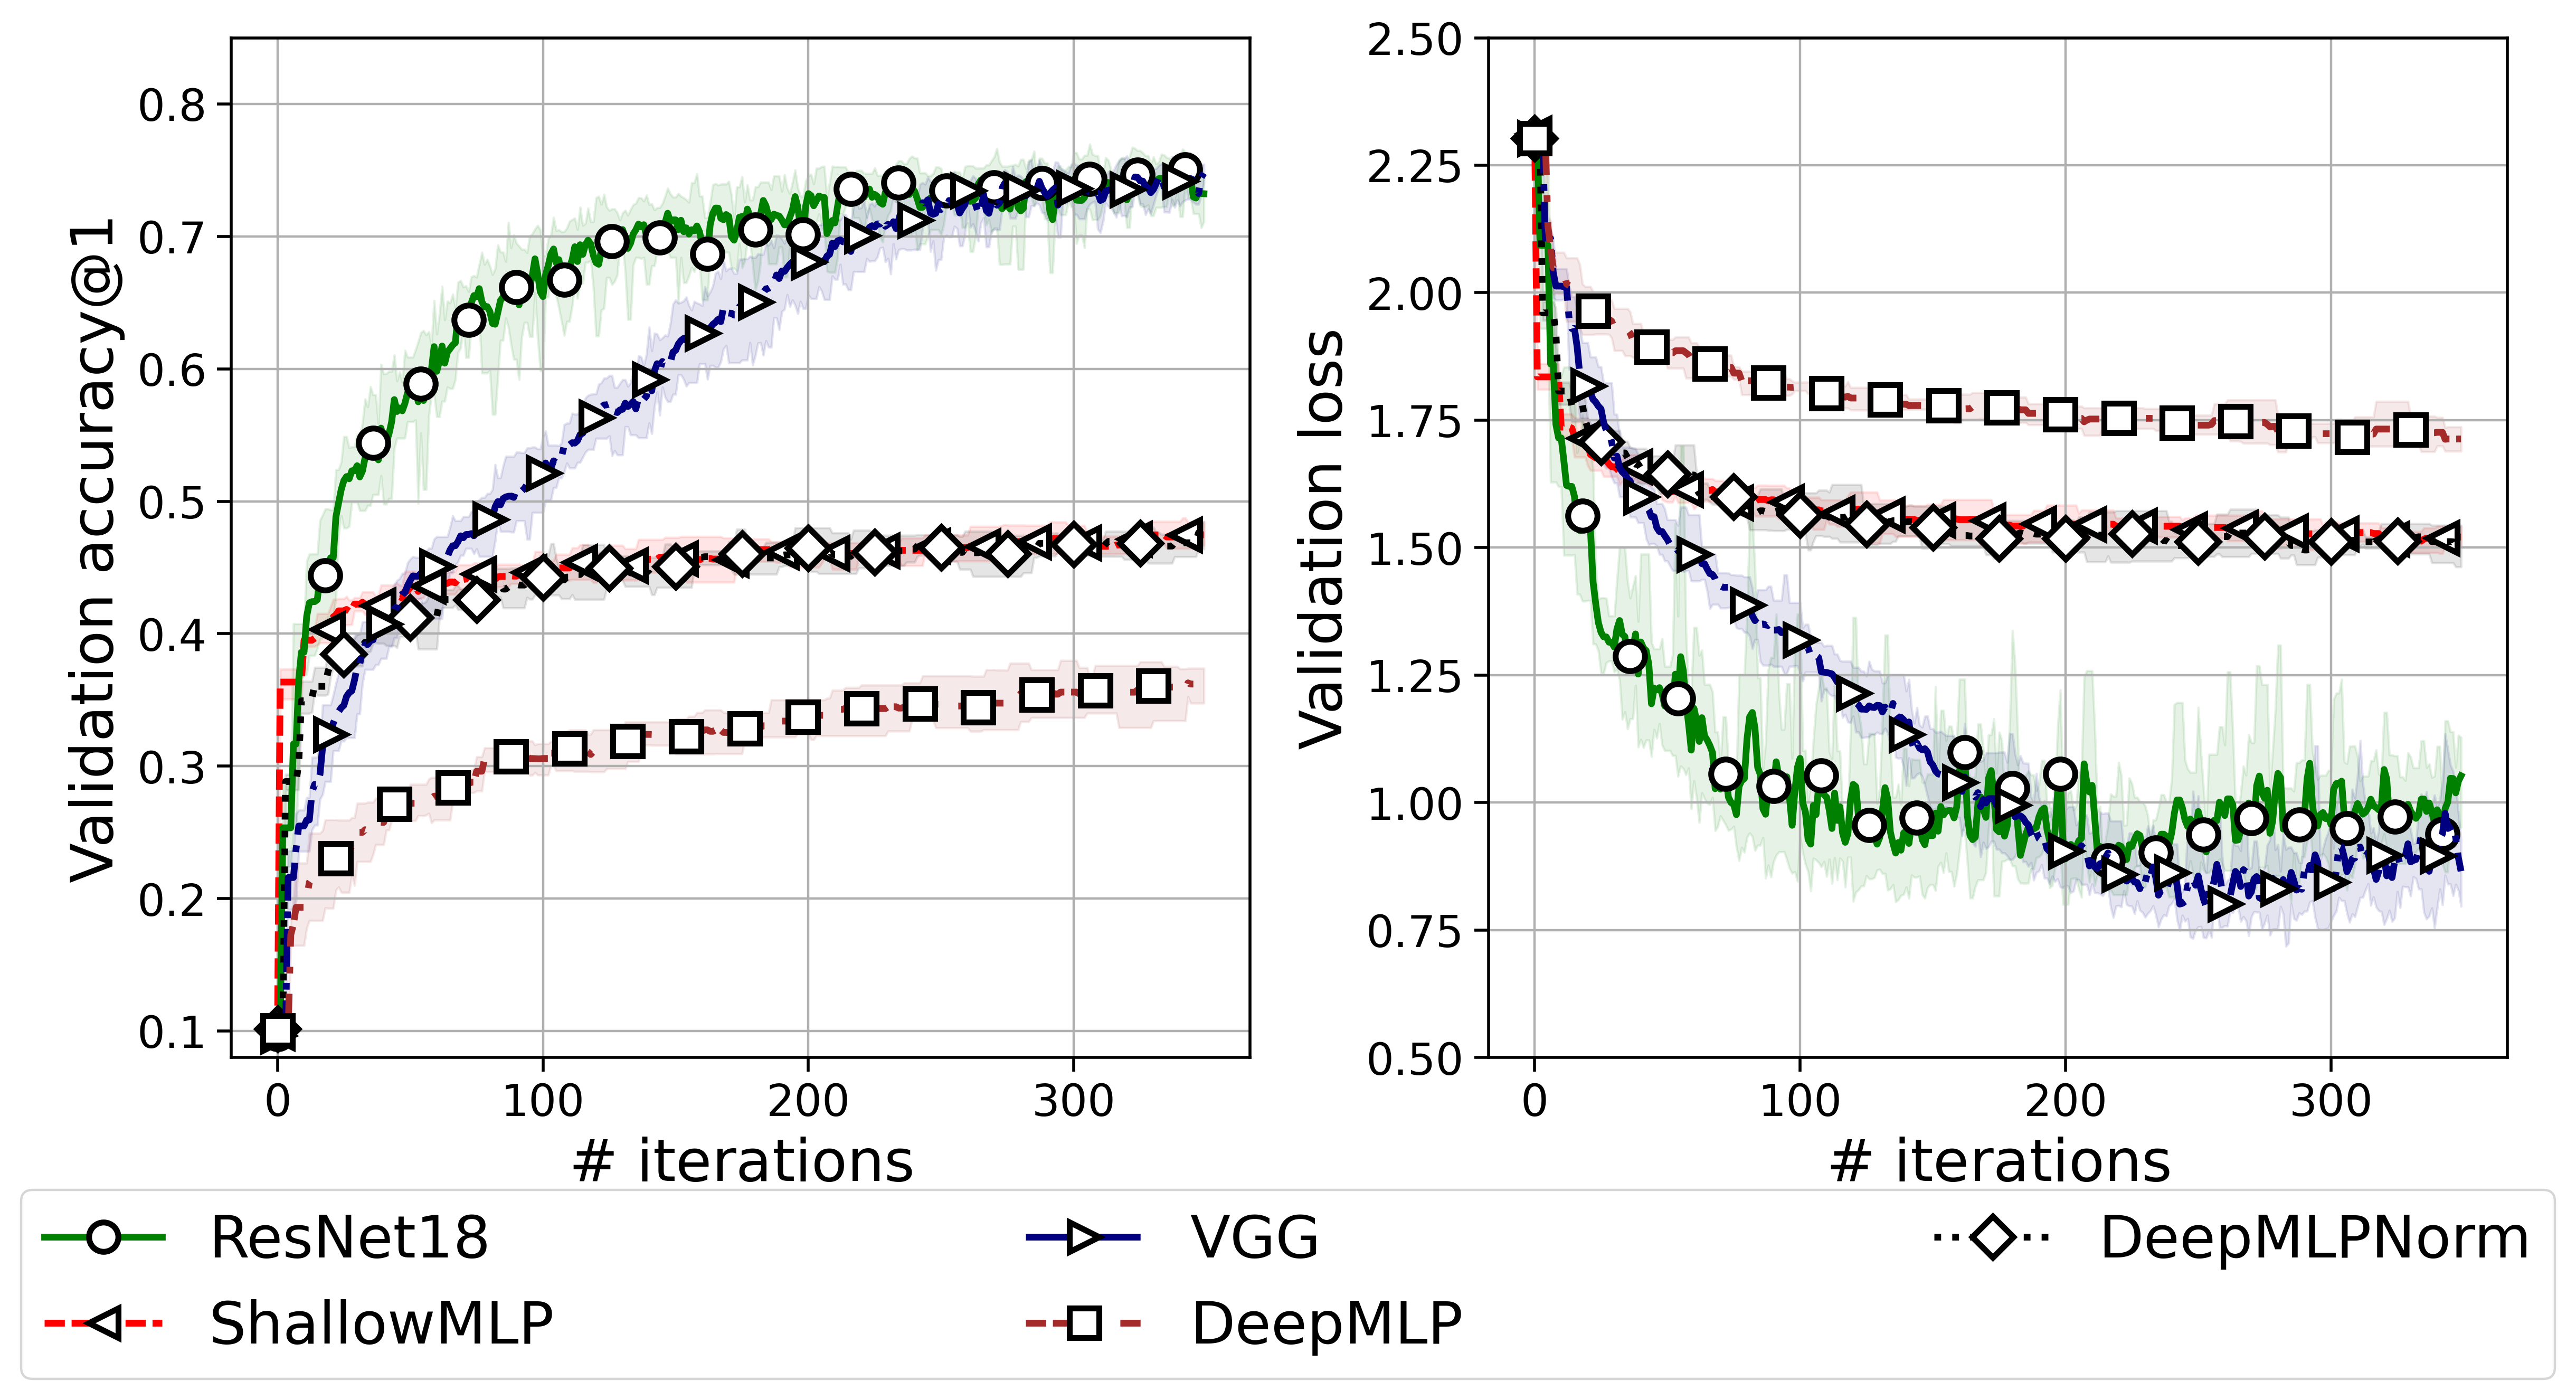

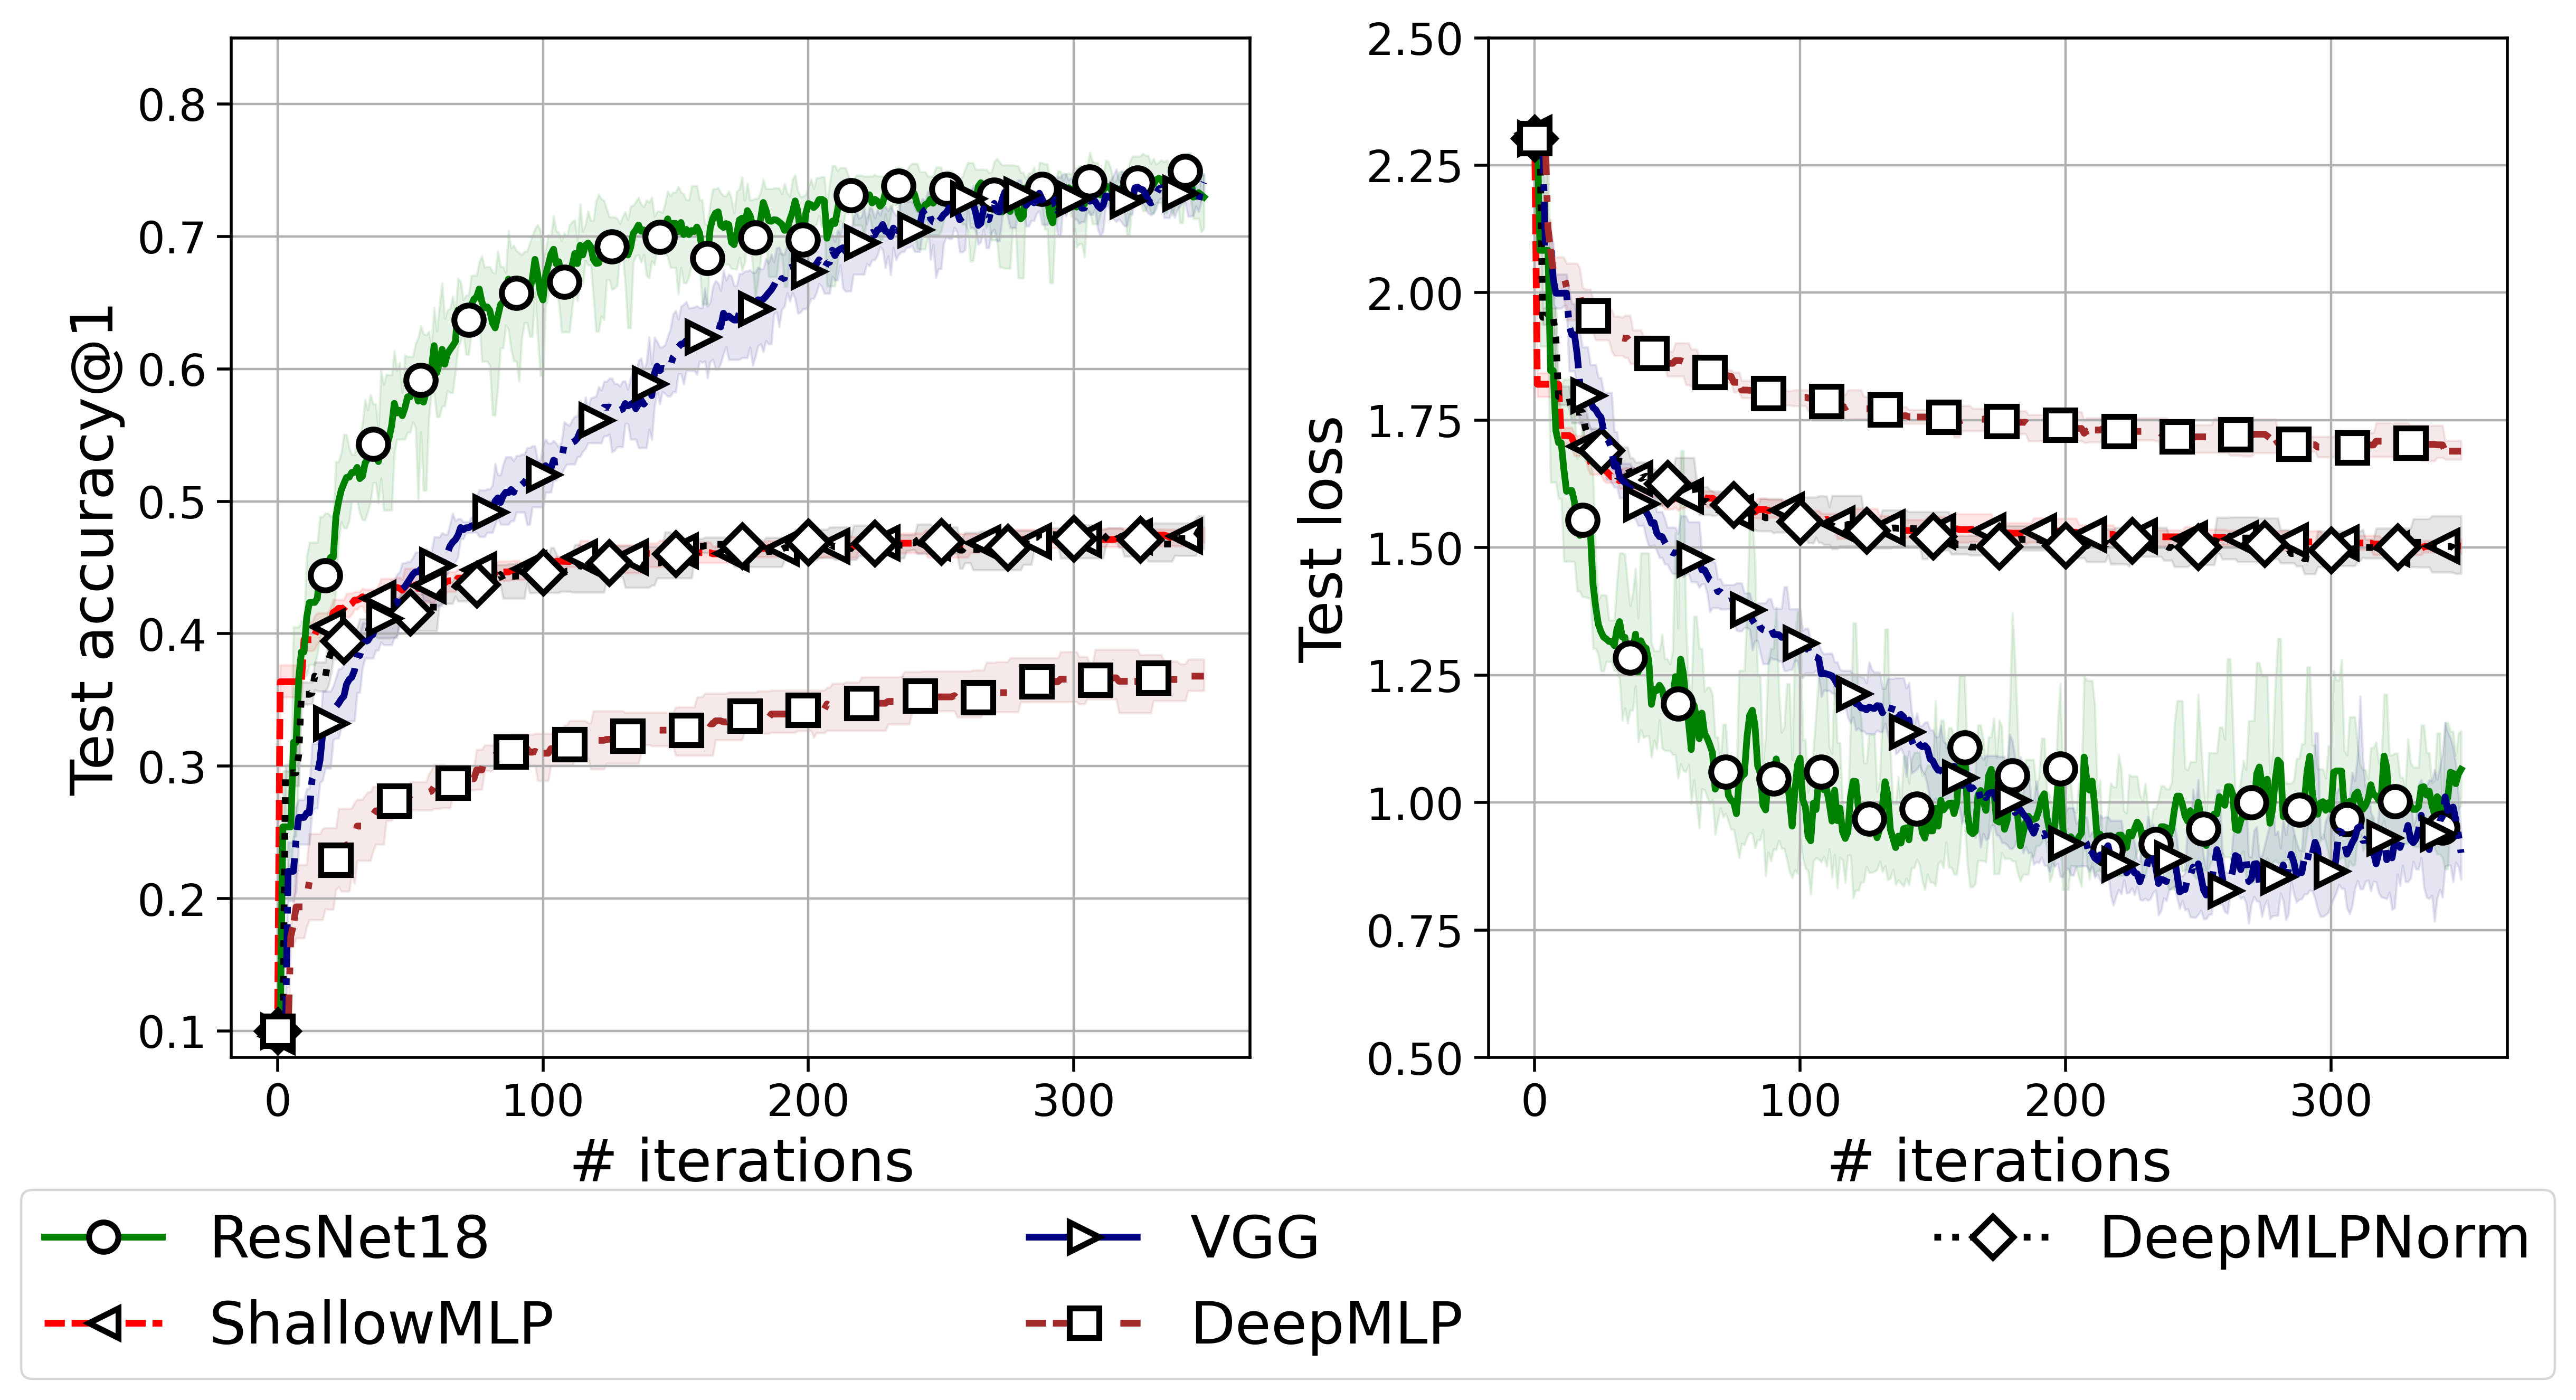

In [ ]:
from multiobjective_opt.utils import LINESTYLES
from multiobjective_opt.utils import get_fig_set_style
LINESTYLES = [
    ("densely dashed", (0, (3, 1))),
    ("d", "solid"),
    ("d", "dotted"),
    ("d", "dashdot"),
    ("dashdotted", (0, (3, 1, 3, ))),
    ("densely dashed", (0, (5, 1))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("long dash with offset", (1, (1, 0))),
    ("dashed", (0, (5, 5))),
    ("d", "dashed"),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
    ("densely dashdotted", (0, (3, 1, 1, 1))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("densely dotted", (0, (1, 1))),
    ("long dash with offset", (5, (10, 3))),
    ("loosely dashdotted", (0, (3, 10, 1, 10))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("loosely dashed", (0, (5, 10))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
]

import matplotlib.pyplot as plt

import numpy as np
# def get_loss_hist(key = "loss"):
#     run_loss_hist = []

#     for run_id in exps['run_id']:
#         try:
#             artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
#             with open(artifact_path, "r") as f:
#                     rf = json.load(f)
#         except Exception as e:
#              continue
#         # print(rf)
#         # if len(rf) == 200:
#         duration, key_res = parse_values(rf)

#         loss_hist = key_res[key].T
#         run_loss_hist.append(loss_hist)
#     return run_loss_hist

def get_loss_hist(key = "loss"):
    run_loss_hist = [r[1][key].T for r in results]
    return run_loss_hist



# from multiobjective_opt.utils import LINESTYLES, get_fig_set_style
def plot_vals(ax, run_hist, ylabel, ylim):
    losses = np.stack(run_hist)
    mean_loss = losses.mean(0)
    low_loss = np.quantile(losses, 0.1, 0)
    high_loss = np.quantile(losses, 0.9, 0)


    colors = ["r", "g", "black", "navy", "brown", "blue", "purple", 'darkgreen',]
    markers = ["<", "o", "D", ">", 's']
    nums = [19, 18, 25, 20, 22]
    # model_names = [elem[0] for elem in list(tab.values())[1]]
    model_names = ["VGG", "Resnet18", "ShallowMLP", "DeepMLP", "DeepMLPNorm"]
    model_names = ['ShallowMLP', 'ResNet18', 'DeepMLPNorm', 'VGGLike', 'DeepMLP']
    # model_names = ["Linear", "MLP", "Conv2Layer", "Conv3Layer", "ConvDropout", "ConvBatchNorm", "ResNet18"]
    for i, (loss, low, high, color, m_name, ls, m, n) in enumerate(zip(mean_loss, low_loss, high_loss, colors, model_names, LINESTYLES, markers, nums)):
        # plt.fill_between(x, loss - std,loss + std , color=color, alpha=0.1,)
        if m_name == "VGGLike":
             m_name = "VGG"
        if "Conv" in m_name:
             continue
        ax.plot(loss, label = m_name, color = color, linestyle=ls[1], marker = m, 
                            markersize = 10, 
                            markeredgewidth=2, 
                            markerfacecolor='white',
                            markeredgecolor='black',
                            markevery = n)
        print(m_name, ls[0])
        x = np.arange(len(loss))
        # if m_name in ["ResNet18", "ConvBatchNorm"]:
        ax.fill_between(x, low, high, color=color, alpha=0.1,)

    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\#$ iterations")
    ax.grid()
    # ax.legend()

fig, ax, _ = get_fig_set_style(7, shape=(1,2), figsize=(12,6))
ax[1].grid()
plot_vals(ax[0], get_loss_hist("accuracy"), "Validation accuracy@1", (0.08, 0.85))
plot_vals(ax[1], get_loss_hist("loss"), " Validation loss", (0.5, 2.5))
h, legend_ = ax[0].get_legend_handles_labels()

pos = [1, 0, 3, 4, 2]
print(legend_)
legend_, h = [legend_[p] for p in pos], [h[p] for p in pos]
fig.legend(
    h,
    legend_,
    ncol=3,
    bbox_to_anchor=(0.0, -0.06, 1, 0.10),
    loc="outside upper left",
    mode="expand",
    borderaxespad=0,
)

fig.tight_layout()
# fig = fig.subplots_adjust(bottom=0.1)
figs = {"both": fig}

fig, ax, _ = get_fig_set_style(7, shape=(1,2), figsize=(12,6))
ax[1].grid()
plot_vals(ax[0], get_loss_hist("test_accuracy"), "Test accuracy@1", (0.08, 0.85))
plot_vals(ax[1], get_loss_hist("test_loss"), " Test loss", (0.5, 2.5))
h, legend_ = ax[0].get_legend_handles_labels()

pos = [1, 0, 3, 4, 2]
print(legend_)
legend_, h = [legend_[p] for p in pos], [h[p] for p in pos]
fig.legend(
    h,
    legend_,
    ncol=3,
    bbox_to_anchor=(0.0, -0.06, 1, 0.10),
    loc="outside upper left",
    mode="expand",
    borderaxespad=0,
)

fig.tight_layout()
# fig = fig.subplots_adjust(bottom=0.1)
figs = {"test_both": fig}
# ax.grid()


# figs = {}
# figs["acc"] = plot_vals(get_loss_hist("accuracy"), "Accuracy", (0.2, 1.))
# figs["loss"] = plot_vals(get_loss_hist("loss"), "Loss", (0.5, 2.1))

In [ ]:
import os
from pathlib import Path
from multiobjective_opt.utils import savefig
savepath = Path("./exp_results/figures/cv")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name, bbox_inches="tight")

### тренировка до точности в 1 процент

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

In [ ]:
from itsdangerous import TimestampSigner
import mlflow
from mlflow.tracking import MlflowClient

# Инициализация клиента MLflow
client = MlflowClient()

# Название родительского эксперимента и запуска
experiment_name = "cifar10_simple_min_log_fixed"
parent_run_name = "full_train:08:08"
# parent_run_name = "full_train:10:51"

# Шаг 1: Найти родительский запуск
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент '{experiment_name}' не найден.")

# Поиск родительского запуска по имени
parent_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{parent_run_name}'"
)

if not parent_runs:
    raise ValueError(f"Родительский запуск '{parent_run_name}' не найден.")

parent_run = parent_runs[0]
parent_run_id = parent_run.info.run_id

# Шаг 2: Найти все дочерние запуски
child_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'"
)

# Шаг 3: Обработка результатов дочерних запусков

def get_loss(key):
    losses = []
    timestamps = []
    alg_names = []
    for run in child_runs:
        run_id = run.info.run_id
        run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
        values = client.get_metric_history(run_id=run.info.run_id, key=key)
        loss = [l.value for l in values]
        times = [l.timestamp for l in values]
        
        losses.append(loss)
        timestamps.append(times)
        alg_names.append(run_name)
        # losses[run_name] = loss
        # timestamps[run_name] = times
    return losses, timestamps, alg_names

losses, timestamps, alg_names = get_loss("accuracy")


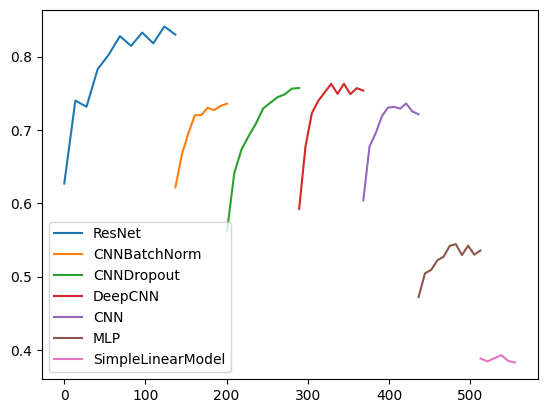

In [ ]:
t_start = 0
times = []
fig, ax = plt.subplots()
for i, (l, t, n) in enumerate(zip(losses, timestamps, alg_names)):
    x = np.array(t) -t[0] + t_start
    t_start = x[-1]
    x = x/1000
    times.append(x)
    ax.plot(x, l,label = n)
ax.legend()

In [ ]:
times = np.concat(times)


In [ ]:
times[-1]

np.float64(555.484)

In [ ]:
from itsdangerous import TimestampSigner
import mlflow
from mlflow.tracking import MlflowClient


def get_duration(timestamps):
    t_start = 0
    t_end = 0
    for t in timestamps:
        x = np.array(t) -t[0] + t_start
        t_start = x[-1]
        x = x/1000
        t_end = x[-1]
    return t_end

def get_loss(key, child_runs):
    # losses = []
    timestamps = []
    # alg_names = []
    for run in child_runs:
        run_id = run.info.run_id
        run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
        values = client.get_metric_history(run_id=run.info.run_id, key=key)
        loss = [l.value for l in values]
        times = [l.timestamp for l in values]
        
        losses.append(loss)
        timestamps.append(times)
        alg_names.append(run_name)
        # losses[run_name] = loss
        # timestamps[run_name] = times
    return get_duration(timestamps)


# Инициализация клиента MLflow
client = MlflowClient()

# Название родительского эксперимента и запуска
experiment_name = "cifar10_simple_min_log_fixed"
parent_run_name_st = "full_train"

# Шаг 1: Найти родительский запуск
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент '{experiment_name}' не найден.")

# Поиск родительского запуска по имени
parent_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName LIKE '{parent_run_name_st}%'"
)

if not parent_runs:
    raise ValueError(f"Родительский запуск '{parent_run_name}' не найден.")

runtimes = []
for parent_run in parent_runs:
    parent_run_id = parent_run.info.run_id

    # Шаг 2: Найти все дочерние запуски
    child_runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'"
    )


    runtimes.append(get_loss("accuracy", child_runs)/60)


In [ ]:
np.mean(runtimes), np.std(runtimes)

(np.float64(9.853473333333334), np.float64(0.3511333812100462))

In [ ]:
from multiobjective_opt.neural_net.utils.dataset_prepare import CIFAR10Handler
handler = CIFAR10Handler()
tr, test = handler.load_dataset()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
i = 0
for _ in tr.get_iterator():
    i += 1
i

391

## табличка с параметрами моделей

In [ ]:
import torch
from multiobjective_opt.neural_net.models.cifar_models import (
    CNN,
    MLP,
    CNNBatchNorm,
    CNNDropout,
    DeepCNN,
    ResNet18,
    SimpleLinearModel,
)
model_names_new = ["Linear", "MLP", "Conv2Layer", "Conv3Layer", "ConvDropout", "ConvBatchNorm", "ResNet18"]

from multiobjective_opt.neural_net.models.cifar_models import (
    CNN,
    MLP,
    CNNBatchNorm,
    CNNDropout,
    DeepCNN,
    ResNet18,
    SimpleLinearModel,
)
from multiobjective_opt.neural_net.models.cifar_models import (
    ResNet18Torch,
    DeepMLP,
    ShallowMLP,
    VGGLike,
    ViTModel
)
from multiobjective_opt.neural_net.models.cifar_vit import ViTSmall

def get_models():
    models = {
        # "SimpleLinearModel": SimpleLinearModel(),
        # "FullyConnectedModel": MLP(),
        # "Conv2LayerModel": CNN(),
        # "Conv3LayerModel": DeepCNN(),
        "ShallowMLP": ShallowMLP(),
        "DeepMLP": DeepMLP(False),
        "DeepMLPNorm": DeepMLP(),
        "VGGLike": VGGLike(),
        "ResNet18": ResNet18(),
        # "ConvDropout": CNNDropout(),
        # "ConvBatchNorm": CNNBatchNorm(),
        # "ResNet18_no": ResNet18(with_shortcut=False),
        # "ResNet18Torch": ResNet18Torch(),
            # "ResNet18": ResNet18Torch(),
            # "ViTModel": ViTModel()
            # "ViTSmall": ViTSmall()
    }
    return models



In [ ]:
import torch
import torch.nn as nn
# from torchsummary import summary
from tabulate import tabulate

def analyze_model(model):
    # Словарь для хранения информации о модели
    model_info = {
        "Total Parameters": 0,
        "Conv Layers": 0,
        "Conv Parameters": 0,
        "Normalization Layers": 0,
        # "Dropout Layers": 0,
    }

    # Перебор всех модулей модели
    for name, module in model.named_modules():
        # Подсчет общего числа параметров
        if isinstance(module, nn.Conv2d):
            model_info["Conv Layers"] += 1
            model_info["Conv Parameters"] += sum(p.numel() for p in module.parameters())
        elif isinstance(module, (nn.BatchNorm2d,nn.BatchNorm1d, nn.LayerNorm, nn.GroupNorm)):
            model_info["Normalization Layers"] += 1
        # elif isinstance(module, nn.Dropout):
            # model_info["Dropout Layers"] += 1

    # Подсчет общего числа параметров
    model_info["Total Parameters"] = sum(p.numel() for p in model.parameters())
    model_info["Total Parameters"] = f"{model_info["Total Parameters"]/1e6:.2f}M"
    model_info["Conv Parameters"] = f"{model_info["Conv Parameters"]/1e6:.2f}M"
    return model_info

def print_model_table(models):
    # Создание таблицы
    table = []
    headers = ["Model", "Total Parameters", "Conv Layers", "Conv Parameters", r"$\#$ Normalizatios", r"$\#$ Dropouts"]

    for name, model in models.items():
        info = analyze_model(model)
        table.append([name, info["Total Parameters"], info["Conv Layers"], info["Conv Parameters"], info["Normalization Layers"], ])

    # Вывод таблицы
    print(tabulate(table, headers=headers, tablefmt="latex_booktabs"))

# Пример использования
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# # Создание моделей
# model1 = SimpleCNN()
# model2 = SimpleCNN()  # Вторая модель для примера

# Анализ и вывод таблицы
# models = {"Model 1": model1, "Model 2": model2}
print_model_table(get_models(), )


\begin{tabular}{llrlr}
\toprule
 Model       & Total Parameters   &   Conv Layers & Conv Parameters   &   \$\textbackslash{}\#\$ Normalizatios \\
\midrule
 ShallowMLP  & 12.64M             &             0 & 0.00M             &                    1 \\
 DeepMLP     & 11.55M             &             0 & 0.00M             &                    0 \\
 DeepMLPNorm & 11.57M             &             0 & 0.00M             &                    9 \\
 VGGLike     & 11.47M             &             6 & 4.58M             &                    0 \\
 ResNet18    & 11.17M             &            20 & 11.16M            &                   20 \\
\bottomrule
\end{tabular}


In [ ]:
inp = torch.rand(5,3,32,32)
ResNet18(with_shortcut=False)(inp)

tensor([[-0.2005,  0.1161, -0.2194, -0.0697,  0.2393,  0.2797, -0.0130,  0.0351,
         -0.0084,  0.0116],
        [-0.1293,  0.2101, -0.3290,  0.1643,  0.2356,  0.2651, -0.0171,  0.0533,
          0.0131, -0.0251],
        [-0.1251,  0.2002, -0.2674,  0.2206,  0.2752,  0.2862, -0.1472,  0.0535,
          0.0775,  0.0440],
        [-0.1133,  0.2513, -0.2848,  0.3098,  0.3257,  0.1450, -0.0784,  0.0846,
         -0.0154, -0.0779],
        [-0.2676,  0.1909, -0.3001,  0.0250,  0.2660,  0.1170,  0.0557,  0.0501,
          0.1747, -0.0458]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch
from multiobjective_opt.neural_net.models.cifar_models import (
    ResNet18Torch,
    DeepMLP,
    ShallowMLP,
    VGGLike,
    ViTModel
)

def get_models():
    models = {
        "ResNet18": ResNet18Torch(),
        "DeepMLP_norm": DeepMLP(),
        "DeepMLP": DeepMLP(False),
        "ShallowMLP": ShallowMLP(),
        "VGGLike": VGGLike(),
        "ViTModel": ViTModel()
    }

    return models
models = get_models()

print_model_table(models, )

\begin{tabular}{llrrrr}
\toprule
 Model        & Total Parameters   &   Conv Layers &   Conv Parameters &   \$\textbackslash{}\#\$ Normalizatios &   \$\textbackslash{}\#\$ Dropouts \\
\midrule
 ResNet18     & 11.2M              &            20 &          11159232 &                   20 &               0 \\
 DeepMLP\_norm & 11.6M              &             0 &                 0 &                    9 &               0 \\
 DeepMLP      & 11.6M              &             0 &                 0 &                    0 &               0 \\
 ShallowMLP   & 12.6M              &             0 &                 0 &                    1 &               0 \\
 VGGLike      & 11.5M              &             6 &           4576384 &                    0 &               0 \\
 ViTModel     & 10.9M              &             1 &             16464 &                   16 &              24 \\
\bottomrule
\end{tabular}


In [ ]:
!pip install einops

In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit_for_small_dataset.py

from math import sqrt
import torch
import torch.nn.functional as F
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    

net = ViT(
image_size = (32,32),
patch_size = 4,
num_classes = 10,
dim = int(512),
depth = 4,
heads = 6,
mlp_dim = 256,
dropout = 0.1,
emb_dropout = 0.1
)


In [ ]:

net = ViT(
image_size = (32,32),
patch_size = 4,
num_classes = 10,
dim = int(512),
depth = 4,
heads = 6,
mlp_dim = 256,
dropout = 0.1,
emb_dropout = 0.1
)


In [ ]:
inp = torch.rand((5, 3,32,32))

net(inp)

tensor([[-0.5202,  0.8741,  0.1643, -0.1941,  0.3869,  0.7443, -0.7216,  0.3372,
          1.0768, -0.9698],
        [-0.2772,  0.6423, -0.1644, -0.3500,  0.2431,  0.4828, -0.2646,  0.2737,
          1.0422, -0.7947],
        [-0.4504,  0.4744, -0.1682, -0.6852,  0.2097,  0.6350, -0.9505,  0.8306,
          0.5565, -0.7586],
        [-0.5798,  0.8748,  0.1114, -0.2541,  0.3291,  0.5733, -0.2877,  0.5916,
          0.9622, -0.6736],
        [-0.3589,  0.5205,  0.0260, -0.1473,  0.5473,  0.4673, -0.4049, -0.3155,
          1.0385, -0.8894]], grad_fn=<AddmmBackward0>)

In [ ]:
print_model_table({"TVIT": net})

\begin{tabular}{lrrrrr}
\toprule
 Model   &   Total Parameters &   Conv Layers &   Conv Parameters &   \$\textbackslash{}\#\$ Normalizatios &   \$\textbackslash{}\#\$ Dropouts \\
\midrule
 TVIT    &            4371438 &             0 &                 0 &                   10 &              13 \\
\bottomrule
\end{tabular}
